# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline




Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name='Tennis.app', seed=1)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.63803244 -1.5
 -0.          0.          6.00063038  6.         -0.          0.        ]


### 3. Load network code


In [4]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*2, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*2), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 4. Load agent code

In [5]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object."""
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.t_step = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
                
        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay or Prioritized Replay Memory
#        self.memory = ReplayBuffer(BATCH_SIZE, BUFFER_SIZE, random_seed)
        self.memory = PrioritizedReplay(BATCH_SIZE, BUFFER_SIZE, random_seed, ALPHA)
    
    def step(self, state, action, reward, next_state, done, agent_number, beta):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.t_step += 1
        self.append_sample(state, action, reward, next_state, done, agent_number)

        # Learn, if enough samples are available in memory
        if self.memory.ready():
            if self.t_step % UPDATE_EVERY == 0:
                for _ in range(N_UPDATES):
                    experiences = self.memory.sample(beta)
                    self.learn(experiences, GAMMA, agent_number)

    def append_sample(self, state, action, reward, next_state, done, agent_number):
        """ save sample (s,a,r,s',d,e) to the prioritized experience replay memory"""
               
        self.actor_target.eval()
        self.critic_target.eval()
        self.critic_local.eval()

        state = torch.from_numpy(state).float().to(device)
        next_state = torch.from_numpy(next_state).float().to(device)
        action = torch.from_numpy(action).float().to(device)
        
        with torch.no_grad():
            # Expected next actions from Actor target network based on state
            actions_next = self.actor_target(state)

            if agent_number == 0:
                actions_next = torch.cat((actions_next, action[:,2:]), dim=1)
            elif agent_number == 1:
                actions_next = torch.cat((action[:,:2], actions_next), dim=1)
        
            # Predicted Q value from Critic target network
            Q_targets_next = self.critic_target(next_state, actions_next)
            Q_targets = reward + (GAMMA * Q_targets_next * (1 - done))

            # Actual Q value based on reward rec'd at next step + future expected reward from Critic target network
            Q_expected = self.critic_local(state, action)
            
        error = (Q_expected - Q_targets)**2
        self.memory.add(state, action, reward, next_state, done, error)

        self.critic_local.train()
        self.actor_target.train()
        self.critic_target.train()

    def act(self, states, add_noise):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        if add_noise:
            actions += eps * self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, agent_number):
        """Update policy and value parameters using given batch of experience tuples."""
        states, actions, rewards, next_states, dones, is_weight, idxs = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
                    
        if agent_number == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
            
        # Predicted Q value from Critic target network
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Actual Q value based on reward received at next step plus future expected rewards from Critic target network
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)

        # Update priority in PER
        loss  = (Q_expected - Q_targets).pow(2).reshape(is_weight.shape) * is_weight
        self.memory.update(idxs, loss.data.cpu().numpy())

        # Minimize critic loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        
        if agent_number == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)

        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters."""
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.13, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
        
    
class PrioritizedReplay:
    """Fixed-size buffer to store prioritized experience tuples."""

    def __init__(self, batch_size, buffer_size, seed, alpha):
        """Initialize a ReplayBuffer object."""

        self.memory = deque(maxlen=buffer_size)
        self.priorities = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        self.alpha = alpha
        self.epsilon = 1e-5       
          
    def add(self, state, action, reward, next_state, done, priority):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        self.priorities.append(priority)
    
    def sample(self, beta):
        """Randomly sample a batch of experiences from memory."""
        priorities = np.array(self.priorities).reshape(-1)
        priorities = np.power(priorities + self.epsilon, self.alpha)  # add a small value epsilon to ensure numeric stability
        p = priorities/np.sum(priorities)  # compute a probability density over the priorities
        sampled_indices = np.random.choice(np.arange(len(p)), size=self.batch_size, p=p)  # choose random indices given p
        experiences = [self.memory[i] for i in sampled_indices]     # subset the experiences
        p = np.array([p[i] for i in sampled_indices]).reshape(-1)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        weights = np.power(len(experiences) * p, -beta)
        weights /= weights.max()
        weights = torch.from_numpy(weights).float().to(device)

        return (states, actions, rewards, next_states, dones, weights, sampled_indices)

    def update(self, indices, priorities):
        """Update the priority values after training given the samples drawn."""
        for i, priority in zip(indices, priorities):
            self.priorities[i] = priority

    def ready(self):
        """Return the current size of internal memory."""
        return len(self.memory) >= self.batch_size

### 5. Set model parameters

In [6]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e6)  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
TAU = 6e-2              # for soft update of target parameters
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 1        # time steps between network updates
N_UPDATES = 1           # number of times training

ALPHA = .2              # Prioritized Experience Replay 1 = full prioritization, 0 = no prioritization
BETA_START = .1         # Prioritized Experience Replay - What degree to use importance weights (0 - no corrections, 1 - full correction)

ADD_NOISE = True
NOISE_START = 6
NOISE_END = 0
NOISE_DECAY = 225

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

agent_0 = Agent(state_size, action_size, 1, random_seed=0)
agent_1 = Agent(state_size, action_size, 1, random_seed=0)


In [ ]:
n_episodes = 2000
scores_window = deque(maxlen=100)
scores_all = []
rolling_average = []

beta_schedule = lambda episode: min(1.0, BETA_START + episode * (1.0 - BETA_START) / n_episodes)

noise_schedule = lambda episode: max(NOISE_END, NOISE_START - episode * ((NOISE_START - NOISE_END) / NOISE_DECAY))

for i_episode in range(1, n_episodes+1):
    beta = beta_schedule(i_episode)
    eps = noise_schedule(i_episode)
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    agent_0.reset()
    agent_1.reset()
    scores = np.zeros(num_agents)
    while True:
        action_0 = agent_0.act(states, ADD_NOISE)           # select an action (for each agent)
        action_1 = agent_1.act(states, ADD_NOISE)           # select an action (for each agent)
        actions = np.concatenate((action_0, action_1), axis=0)
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]           # send all actions to the environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        next_states = np.reshape(next_states, (1, 48))
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                         # see if episode finished
        if np.any(dones):                                   # if either agent fails, episode over
            done = True
        else:
            done = False
        agent_0.step(states, actions, rewards[0], next_states, done, 0, beta)
        agent_1.step(states, actions, rewards[1], next_states, done, 1, beta)
        scores += rewards                                  # update the score (for each agent)
        states = next_states                                # roll over states to next time step

        if np.any(done):                                  # exit loop if episode finished
            break

    scores_window.append(np.max(scores))
    scores_all.append(np.max(scores))
    rolling_average.append(np.mean(scores_window))
                
    if i_episode % 10 == 0:
        print('Episode {}\tMax Reward: {:.3f}\tAverage Reward: {:.3f}'.format(
            i_episode, np.max(scores), np.mean(scores_window)))

    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
            i_episode-100, np.mean(scores_window)))
        torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
        torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
        torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
        torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        break



Episode 10	Max Reward: 0.000	Average Reward: 0.010
Episode 20	Max Reward: 0.000	Average Reward: 0.005
Episode 30	Max Reward: 0.000	Average Reward: 0.003
Episode 40	Max Reward: 0.000	Average Reward: 0.005
Episode 50	Max Reward: 0.000	Average Reward: 0.006
Episode 60	Max Reward: 0.000	Average Reward: 0.005
Episode 70	Max Reward: 0.000	Average Reward: 0.004
Episode 80	Max Reward: 0.000	Average Reward: 0.005
Episode 90	Max Reward: 0.000	Average Reward: 0.007
Episode 100	Max Reward: 0.000	Average Reward: 0.007
Episode 110	Max Reward: 0.000	Average Reward: 0.008
Episode 120	Max Reward: 0.090	Average Reward: 0.011
Episode 130	Max Reward: 0.000	Average Reward: 0.014
Episode 140	Max Reward: 0.000	Average Reward: 0.017
Episode 150	Max Reward: 0.000	Average Reward: 0.020
Episode 160	Max Reward: 0.100	Average Reward: 0.025
Episode 170	Max Reward: 0.000	Average Reward: 0.028
Episode 180	Max Reward: 0.090	Average Reward: 0.032
Episode 190	Max Reward: 0.100	Average Reward: 0.035
Episode 200	Max Rewar

Episode 1580	Max Reward: 0.200	Average Reward: 0.280
Episode 1590	Max Reward: 0.100	Average Reward: 0.275
Episode 1600	Max Reward: 0.100	Average Reward: 0.304
Episode 1610	Max Reward: 0.400	Average Reward: 0.314
Episode 1620	Max Reward: 0.300	Average Reward: 0.329
Episode 1630	Max Reward: 0.190	Average Reward: 0.325
Episode 1640	Max Reward: 0.100	Average Reward: 0.320
Episode 1650	Max Reward: 0.090	Average Reward: 0.315
Episode 1660	Max Reward: 0.090	Average Reward: 0.295
Episode 1670	Max Reward: 0.100	Average Reward: 0.285
Episode 1680	Max Reward: 0.100	Average Reward: 0.266
Episode 1690	Max Reward: 0.100	Average Reward: 0.297
Episode 1700	Max Reward: 0.100	Average Reward: 0.373


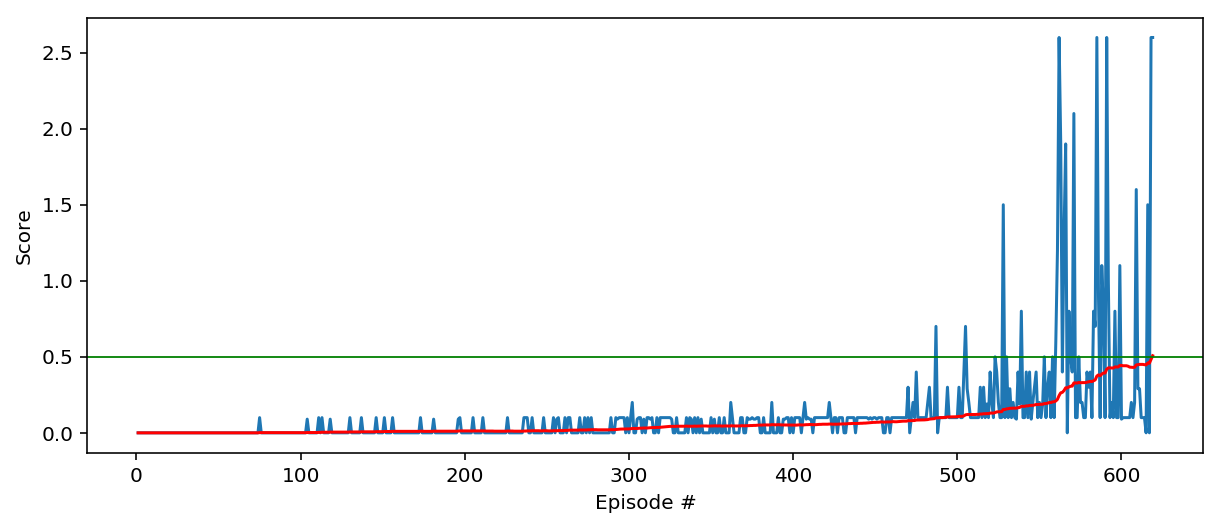

In [8]:
fig = plt.figure(figsize=(10,4))

ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average, color='r')
plt.ylabel('Score')
plt.xlabel('Episode #')

#plot goal line
plt.axhline(y=0.5, xmin=0.0, xmax=1.0, color='g', linestyle='-', linewidth=.9)
%config InlineBackend.figure_format = 'retina'
plt.show()

In [1]:
# Load the saved training parameters
agent_0.actor_local.load_state_dict(torch.load('checkpoint_actor_0.pth', map_location='cpu'))
agent_0.critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth', map_location='cpu'))
agent_1.actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth', map_location='cpu'))
agent_1.critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth', map_location='cpu'))

# Set environment to evalulation mode
env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
states = np.reshape(states, (1,48))

for i in range(700):
    action_0 = agent_0.act(states, add_noise=False)         
    action_1 = agent_1.act(states, add_noise=False)        
    actions = np.concatenate((action_0, action_1), axis=0) 
    actions = np.reshape(actions, (1, 4))
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    states = next_states                              
    if np.any(dones):                              
        break

NameError: name 'agent_0' is not defined